In this demo, I will show you how to setup a Kubernetes cluster and run DATC RDF there.

To run this demo, we need Docker Desktop installed. You can find the installation instruction at the following link.

* Link: https://docs.docker.com/desktop/#download-and-install

# Kubernetes Cluster Setup

## Cluster Installation

Docker Desktop includes a single-node Kubernetes cluster. We will use that cluster for this demo. 
Open Docker Desktop window, go to preferene, and enable the Kubernetes as shown in the following screenshot.
Then it will install a single-node Kubernetes cluster on your laptop.

![Docker desktop](./figs/docker-desktop.png)

Now, we check the installation.

We use `kubectl`, which is the the Kubernetes command line tool.

To check the cluster installation, run the following command, and see whether the Kubernetes context is set as `docker-desktop`.

In [1]:
!kubectl config use-context docker-desktop
!kubectl config current-context

Switched to context "docker-desktop".
docker-desktop


<br/>
We check the available nodes by the following command.

In [2]:
!kubectl get node

NAME             STATUS   ROLES                  AGE   VERSION
docker-desktop   Ready    control-plane,master   8d    v1.21.2


<br />
The Kubernetes cluster looks like this.

<img src="./figs/k8s-single-node-fig1.png" alt="docker-desktop" width="60%"/>

---
## Namespace

We create a namespace where we define our Kubernetes resources.<br/>
The namespace definition is shown below.

```yaml
# rdf-namespace.yaml
apiVersion: v1
kind: Namespace
metadata:
  name: rdf
```

Save the YAML file, and use the `kubectl apply` command to create the namespace.

In [22]:
!kubectl apply -f rdf-namespace.yaml

namespace/rdf created


In [17]:
!kubectl get namespaces

NAME              STATUS   AGE
default           Active   8d
kube-node-lease   Active   8d
kube-public       Active   8d
kube-system       Active   8d
rdf               Active   0s


---
## Volume

We create a volume which we use as storage.<br/>

First, create a directory, called `workspace`, and put the necessary files, which include:

* `experiment`: Design files (`.v`, `.sdc`) and flow configuration file.
* `openroad-flow`: Common OpenROAD flow file for P&R (flow scripts and PDK/libraries).

In [5]:
!ls workspace

experiment  openroad-flow


In [6]:
!ls workspace/experiment

Makefile  config.mk  constraint.sdc  gcd.v


In [7]:
!cat workspace/experiment/config.mk

export DESIGN_NAME   = gcd
export PLATFORM      = sky130hd

export DESIGN_HOME   = ./
export PLATFORM_HOME = ../openroad-flow/platforms
export UTILS_DIR     = ../openroad-flow/util
export SCRIPTS_DIR   = ../openroad-flow/scripts

export VERILOG_FILES = ./gcd.v
export SDC_FILE      = ./constraint.sdc
export ABC_AREA      = 1

export CORE_MARGIN = 1
export CORE_ASPECT_RATIO = 1
export CORE_UTILIZATION = 20
export PLACE_DENSITY = 0.72


In [8]:
!ls workspace/openroad-flow

Makefile  platforms  scripts  util


<br/>

Now, we create a Kubernetes Persistent Volume pointing the local directory `workspace`.

```yaml
# pv.yaml
apiVersion: v1
kind: PersistentVolume
metadata:
  name: rdf-workspace-pv
  labels:
    type: local
spec:
  storageClassName: manual
  capacity:
    storage: 20Gi
  accessModes:
    - ReadWriteMany
  hostPath:
    path: "/workspace"
```

Save the above YAML file and run `kubectl apply`.

In [23]:
!kubectl apply -f pv.yaml

persistentvolume/rdf-workspace-pv created


In [10]:
!kubectl get pv

NAME               CAPACITY   ACCESS MODES   RECLAIM POLICY   STATUS      CLAIM   STORAGECLASS   REASON   AGE
rdf-workspace-pv   20Gi       RWX            Retain           Available           manual                  4s



<br />

To make the volume usable, we create Persistent Volume Claim.

```yaml
# pvc.yaml
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: rdf-workspace-pv-claim
  namespace: rdf
spec:
  storageClassName: manual
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 20Gi
```

Similarly, save the above YAML file and run `kubectl apply`.

In [24]:
!kubectl apply -f pvc.yaml

persistentvolumeclaim/rdf-workspace-pv-claim created


In [12]:
!kubectl --namespace=rdf get pvc rdf-workspace-pv-claim

NAME                     STATUS   VOLUME             CAPACITY   ACCESS MODES   STORAGECLASS   AGE
rdf-workspace-pv-claim   Bound    rdf-workspace-pv   20Gi       RWX            manual         5s


<br/>

At this point, our Kubernetes cluster, `docker-desktop` looks like this.

<img src="./figs/k8s-single-node-fig2.png" alt="docker-desktop" width="60%"/>

---
## Pod

We now create a POD running the RDF Docker container.

* We use the Docker image `jinwookjung/rdf`.
    - Link: https://hub.docker.com/r/jinwookjung/rdf
* We allocate 2 CPUs, 8GB RAM.
* The Persistent Volume is mounted at `/workspace`.

Here's the YAML file to create POD.

```yaml
# pod.yaml
apiVersion: v1
kind: Pod
metadata:
  name: rdf-openroad
  namespace: rdf
spec:
  volumes:
  - name: rdf-workspace
    persistentVolumeClaim:
      claimName: rdf-workspace-pv-claim
  containers:
  - name: shell
    resources:
      limits:
        cpu: 2
        memory: 8Gi
    image: "jinwookjung/rdf"
    command:
    - sleep
    args:
    - infinity
    volumeMounts:
    - name: rdf-workspace
      mountPath: /workspace
```

Save the YAML file and run the `kubectl apply` command.

In [25]:
!kubectl apply -f pod.yaml

pod/rdf-openroad created


In [14]:
!kubectl -n rdf get pod

NAME           READY   STATUS    RESTARTS   AGE
rdf-openroad   1/1     Running   0          6s


<br />

Now, the Kubernetes cluster, `docker-desktop`, looks like this.

<img src="./figs/k8s-single-node-fig3.png" alt="docker-desktop" width="60%"/>

---
# Running P&R Job using DATC-RDF

<br/>

We get into the Pod to make P&R job.

Open a terminal, run the following command.

```bash
kubectl -n rdf exec -it rdf-openroad -- /bin/bash
```

Then, the prompt will change to:

```text
[root@rdf-eoprnaod]# 
```

To make the example task, we run the following command:

```bash
cd /workspace/experiment
make DESIGN_CONFIG=config.mk
```

Once completed, close the pod.

```bash
exit
```

---
# Clean-Up Resources

We clean-up the Kubernetes cluster resources using the `kubectl delete` command (in the reverse order in which resources were created.)

In [26]:
!kubectl delete -f pod.yaml
!kubectl delete -f pvc.yaml
!kubectl delete -f pv.yaml
!kubectl delete -f rdf-namespace.yaml

pod "rdf-openroad" deleted
persistentvolumeclaim "rdf-workspace-pv-claim" deleted
persistentvolume "rdf-workspace-pv" deleted
namespace "rdf" deleted


<br />

The Kubernetes cluster is now back to the clean state.

<img src="./figs/k8s-single-node-fig1.png" alt="docker-desktop" width="60%"/>

# Check Results

The results are stored in `workspace/experiment` directory.

In [27]:
!ls workspace/experiment/results/sky130hd/gcd/base/

1_1_yosys.v		   3_1_place_gp.def	  5_route.sdc
1_synth.sdc		   3_2_place_iop.def	  6_1_fill.def
1_synth.v		   3_3_place_resized.def  6_1_fill.sdc
2_1_floorplan.def	   3_4_place_dp.def	  6_1_merged.gds
2_2_floorplan_io.def	   3_place.def		  6_final.def
2_3_floorplan_tdms.def	   3_place.sdc		  6_final.gds
2_4_floorplan_macro.def    4_1_cts.def		  6_final.sdc
2_5_floorplan_tapcell.def  4_2_cts_fillcell.def   6_final.spef
2_6_floorplan_pdn.def	   4_cts.def		  6_final.v
2_floorplan.def		   4_cts.sdc		  output_guide.mod
2_floorplan.sdc		   4_cts.v		  route.guide
2_floorplan.v		   5_route.def		  updated_clks.sdc


<br/>

Plot the layout images.

Text(0.5, 1.0, 'Resizer output')

<Figure size 432x288 with 0 Axes>

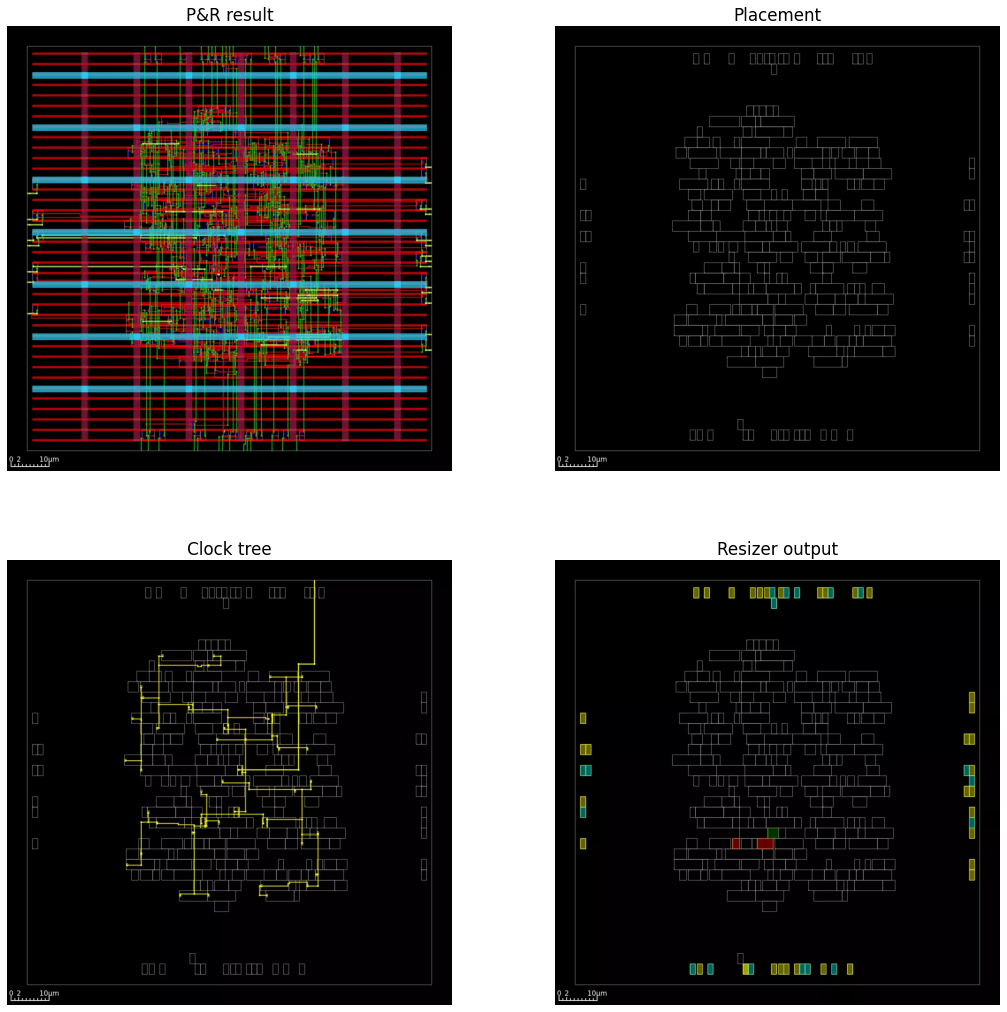

In [28]:
import webp
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
plt.tight_layout()

fig, axs = plt.subplots(2,2)
fig.set_size_inches(18,18)
[axi.set_axis_off() for axi in axs.ravel()]

workspace = "workspace"
report_dir = "{}/experiment/reports/sky130hd/gcd/base".format(workspace)
pnr = webp.load_image("{}/final.webp".format(report_dir))
place = webp.load_image("{}/final_placement.webp".format(report_dir))
clock = webp.load_image("{}/final_clocks.webp".format(report_dir))
resize = webp.load_image("{}/final_resizer.webp".format(report_dir))

axs[0][0].imshow(pnr)
axs[0][1].imshow(place)
axs[1][0].imshow(clock)
axs[1][1].imshow(resize)

axs[0][0].set_title("P&R result")
axs[0][1].set_title("Placement")
axs[1][0].set_title("Clock tree")
axs[1][1].set_title("Resizer output")